#  Aprendizaje Automático

# Trabajo Práctico 1 - Detección de Spam

# Estudiantes: Juan Manuel Perez, Mariela Rajngewerc, Tomás Freilij





#  Ayudas para nosotros

# https://sourceforge.net/p/jupiter/wiki/markdown_syntax/#md_ex_text


 PREGUNTA: ¿Cómo debe ser el informe?

RESPUESTA: Recomendamos armar el informe con las siguientes secciones:

    Extracción de atributos: Describir en castellano los atributos extraidos de los mails, en forma concisa.
    Modelos: Listar los algoritmos de aprendizaje elegidos para experimentar. Describir cualquier decisión que hayan tomado (p.ej., elección de hiperparámetros).
    Reducción de dimensionalidad: Describir brevemente las técnicas empleadas.
    Resultados: Describir los resultados conseguidos por los distintos modelos y conjuntos de atributos considerados. Preferentemente, resumir los resultados en tablas/figuras. Mencionar los tiempos de ejecución aproximados de cada técnica.
    Discusión: Analizar los resultados, buscando responder cuestiones como, por ejemplo: ¿cuáles son los atributos encontrados con mayor poder predictivo?, ¿cuán sensibles fueron los algoritmos a las técnicas de reducción de dimensionalidad consideradas?, ¿resultó clara la elección del algoritmo para la competencia, o hubo que poner en la balanza distintos factores?

La longitud sugerida del informe es de entre 3 y 5 páginas de texto (sin contar tablas o figuras). Además pueden incluirse tablas y figuras, pero siempre deben ser referenciadas y explicadas en el texto.

Si se tomaron ideas de la literatura (papers, libros, blogs, wikipedia o lo que sea), citar claramente las fuentes (autor, título, tipo de publicación, año de publicación, URL si corresponde, etc.).

No incluir código. Si es necesario describir un algoritmo, hacerlo en pseudocódigo

In [1]:
%pylab inline
# Esto agrega al python path el directorio ..
import sys
sys.path.append("..")
import re
import numpy as np
import config
import dateutil
import random
from transformers import transformer
from data_builder import load_test_data, load_dev_data, load_small_dev_data


df, target = load_small_dev_data()


"""
Todo esto está en los transformers, pero como me convierten todo a una matriz
de numpy prefiero hacerlo acá a mano (ok, no es lo más lindo, pero es lo que hay)
"""

receivers = df.parsed_emails.apply(lambda p: p.get_all("To") or p.get_all("to") or [])
senders = df.parsed_emails.apply(lambda p: p.get_all("From") or p.get_all("from") or [])

def join_mails(t):
    return ";".join(t)

def is_ascii(s):
    try:
        s.encode('ascii')
        return True
    except UnicodeDecodeError:
        return False
    
def parse_date(parsed_mail):
    try:
        date = parsed_mail.get('Date') or parsed_mail.get('date')
        return dateutil.parser.parse(date, fuzzy_with_tokens=True)[0]
    except (ValueError, AttributeError):
        return None


df['from_text'] = senders.apply(join_mails)
df['to_text'] = receivers.apply(join_mails)
df['number_of_receivers'] = df['to_text'].apply(lambda t: len(re.findall(r'<.*>', t)))
df['from_non_ascii'] = df.from_text.apply(lambda f: not is_ascii(f))

dates = df.parsed_emails.apply(parse_date)

df['hour'] = dates.apply(lambda t: t.hour if t else random.choice(range(24)))
df['hour_between_7_and_20'] = df['hour'].apply(lambda h: h >= 7 and h <= 21)


df['day_of_month'] = dates.apply(
    lambda d: d.day if d else random.choice(range(29))
)

df['weekday'] = dates.apply(
    lambda d: d.weekday() if d else random.choice(range(6))
)

df['is_weekend'] = df.weekday >= 5

df['year'] = dates.apply(
    lambda d: d.year if d else random.choice(range(1990, 2005))
)

spam = df[target].sample(30)
ham = df[target == False].sample(30)

Populating the interactive namespace from numpy and matplotlib


# Resumen del trabajo

El objetivo de este trabajo fue explorar la performance de distintos clasificadores en la tarea de detección de spam. Se procedió, sobre un corpus de mails etiquetados positiva o negativamente como spam, primeramente a elegir un conjunto de atributos. 

Para cada uno de los tipos de clasificadores explorados (`Decision Tree`, `Random Forest`, `KNN`, `Näive Bayes`, y `Support Vector Machine`) optimizamos sus parámetros para mejorar la performance sobre el dataset, a la vez que investigamos cómo afectaba a su rendimiento la utilización de `Principal Component Analysis`.


# Métodos y Materiales

## Dataset  

El dataset constó de 90000 mails, equilibrados entre `spam` y `ham`. De este total de mails, separamos un 10% para test, y usamos el 90% restante como desarrollo.


## Extracción de Atributos

Los atributos principales que se extrajeron de los mails fueron:

- Atributos generados por TF-IDF (poner referencia)
- Atributos escogidos manualmente

Los atributos extraídos mediante `TF-IDF` fueron realizados sobre el payload del mail y no sobre el texto completo. Para el parsing de los mails en texto plano utilizamos la librería estándar `email`[cita de Python mientras que para la generación de los atributos con `TF-IDF` utilizamos el vectorizador correspondiente de `sklearn`.

Los atributos manuales que extrajimos fueron tanto del header como otros del payload, luego de un análisis observacional del dataset. Del encabezado del mensaje extrajimos:

- El `content-type` del mail: si son texto, imágenes, html, etc o bien una mezcla de estos
- La hora en la que fue enviado
- ¿El mail fue enviado entre las 7 y las 20hs?
- El día de la semana (Lunes a Domingo)
- ¿Fue enviado el fin de semana?
- El día del mes (1-31)
- El año en el que fue enviado 
- La cantidad de receptores del mail
- ¿El nombre del sender tiene algún caracter no ASCII?

Los atributos temporales del mail fueron extraídos luego de analizar el dataset. Por ejemplo, podemos ver en las figuras siguientes que la distribución horaria de los 




Frecuencia de Ham entre 5 y 20 hs = 0.824938271605


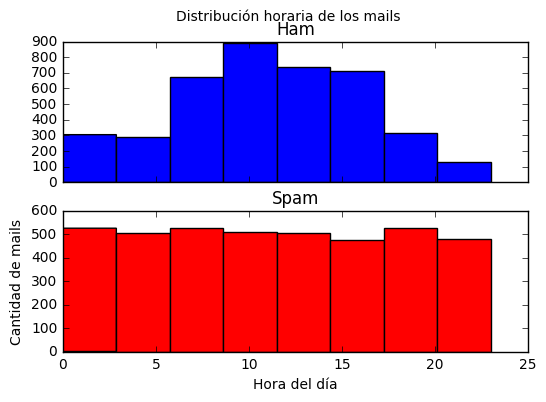

In [78]:
ham = df[np.logical_not(target)]
spam = df[target]

fig, ax = subplots(2, 1, sharex=True)

nbins = 8

ax[0].hist(ham.hour, bins=nbins, range=[0, 23], color="blue");
ax[0].set_title(u"Ham");
ax[1].hist(spam.hour, bins=nbins, range=[0, 23], color="red");
ax[1].set_title(u"Spam");

xlabel(u"Hora del día");
ylabel(u"Cantidad de mails");
suptitle(u"Distribución horaria de los mails");


ham_hours =  ham.hour.value_counts(normalize=True)

ham_hours.sort_index(0, inplace=True)


print "Frecuencia de Ham entre 5 y 20 hs = %s" % sum(ham_hours[5:20])

In [65]:
ax[0].title

## Clasificadores Utilizados

- DecisionTree (JM)
- RandomForest (JM)
- KNN (Okus)
- SVM (Okus)
- Naive Bayes (Okus)
- Explicar los parámetros de cada uno de ellos (que luego optimizamos) 

### Optimización de hiperparámetros

- ROC AUC
- Cross validation (10 vs SVM 3)
- Usamos Randomized (vs Grid)
- PCA (JM)


# Resultados y Discusión

- TABLAS
- Cómo se comportaron con PCA
- 

# Conclusiones



# Decision Trees

# Los hiperparámetros que nos parecieron interesantes, provistos por la librería fueron.

** Criterio de partición ('criterion')** 

Establece la función que mide la calidad de una partición de los nodos del árbol. 
Existen dos provistos por la librería, "Gini" y "Entropía". El último responde al Information Gain visto en la materia.

**Profundidad máxima ('max_depth')**

Permite hacer una poda sobre el árbol. 

**Splitter**

Tiene dos opciones, best y random. Establece si se utiliza el mejor criterio de partición o usa un mecanismo aleatorio para buscarlo. Como ya dijimos antes, la calidad de la partición estará dada por el hiperparámetro 'criterion'

**Subconjunto de valores de un atributo('max_features')**

Establece el máximo de valores de un atributo que se tiene en cuenta. Visto más gráficamente, establece el ancho del árbol.
Se puede establecer un número fijo, o un porcentaje, entre otras posibilidades.

**Criterio de corte para un nodo('min_samples_split')**

La mínima cantidad de muestras necesarias para que se justifique la partición en un nodo. 


** La mejor combinación de hiperparámetros fue **

'min_samples_split' = 82 

'splitter' = 'best' 

'criterion' = 'entropy' 

'max_depth'= 18 

'max_features' = 0.90000000000000013

El valor fue 0.987803482259 con el scoring roc_auc.

 
# VER QUE ONDA CON EL ROC AUC SCORE QUE VARIA CON EL ANTERIOR MOSTRADO 


| precision_score | accuracy_score   |    f1_score 	| recall_score |	roc_auc_score |
|-----------------|------------------|--------------|--------------|------------------|
| 0.956531        | 0.957444         |    0.957487 	|  0.958444    |     0.957444     |



 	   	

 	             	    


# Naive Bayes
   

Dada la naturaleza del clasificador, hay que tener también en cuenta la distribución de las muestras. En ese sentido, la librería provee tres clasificadores de Naive Bayes, usando una distribución Gaussiana, una de Bernoulli y una Multinomial.

Las primeras pruebas arrojaron resultados nulos con la multinomial y la de bernoulli. Cuando hablamos de resultados nulos nos referimos a que, con pruebas varias que hacíamos, la clasificación era completamente errada.

Dado que la Gaussiana no arrojaba ese tipo de resultado, decidimos trabajar con esa propuesta.

Ahora bien, cuando graficábamos la distribución de algunos atributos en los mails veíamos que se parecía más a una Exponencial que a una Gaussiana. Además, los gráficos perdían proporcionalidad y no se podían entender. Al intentar aplicarle logaritmo a los datos para darle otra escala vimos que tomaban una forma de campa de gauss.

Como además aplicar el logaritmo preserva las desigualdades, nos parecía razonable usar esta conversión previa para trabajar con el clasificador.

Este clasificador no tiene parámetros así que no tuvimos que hacer pruebas variadas en relación a modificación de hiperparámetros.

Los resultados obtenidos sin previa normalización usando logaritmo fueron:

 |	precision_score  | accuracy_score  |	f1_score  |	recall_score  |	roc_auc_score | 
 |-------------------|-----------------|--------------|---------------|---------------|  
 |	0.504766 	     |0.509222 	       |    0.665556  |	0.976667 	  | 0.509222      |  
 
 Con normalización fueron:
 
| precision_score |	accuracy_score | f1_score |	recall_score | roc_auc_score |
|-----------------|----------------|----------|--------------|---------------|
| 1.0 	          | 0.500778 	   | 0.003106 |	0.001556 	 |  0.500778     |            
 

# AGREGAR LO DE BERNOULLI QUE APARECIÓ DESPUÉS

# KNN

# SVM

# RANDOM FOREST